# Predict Whether a Credit Card Client Will Default or Not

## Introduction

Machine Learning techniques can be used to make predictions in a variant of areas such as fraud detection, personal recommendation, and weather forecast nowadays. One important role it can play is to determine if the client of a credit card company will default or not, which is the topic of this project. This is a course work our group completed in CPSC 330 (Applied Machine Learning) at the University of the British Columbia. 

The dataset we used is the [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) on Kaggle. The data was collected in Taiwan from April 2005 to September 2005, and the dataset contains some information including basic but not too private factors of the clients, their bill statement and credit data, as well as their payment history. In this project, we used several Machine Learning models and multiple analysis methods to solve such questions: **How well do the models perform on predicting the result, and which factor is the most important to predict whether the client will default or not?** Also, we believe that this project will be beneficial for such banks or credit card companies to analyze their customer status and make better decisions.

## EDA

The data are already cleaned and organized when integrated into the dataset. However, to fit in the future models in our project, some exploratory data analysis still needs to be run. For example, we checked if there were some missing values, and we checked the basic statistics values, such as mean and median values of each feature in the dataset. Moreover, to explore the dataset more, a plot is normally helpful for the analysts to understand the data more intuitively. The bar charts below is showing the count of examples for each feature in the dataset.


First of all, import all the packages that are used in later procedures.

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

pd.set_option("display.max_colwidth", 0)

The data are already cleaned and organized when integrated into the dataset. However, to fit in the future models in our project, some exploratory data analysis still needs to be run. For example, we checked if there were some missing values, and we checked the basic statistics values, such as mean and median values of each feature in the dataset. Moreover, to explore the dataset more, a plot is normally helpful for the analysts to understand the data more intuitively. The bar charts below is showing the count of examples for each feature in the dataset.

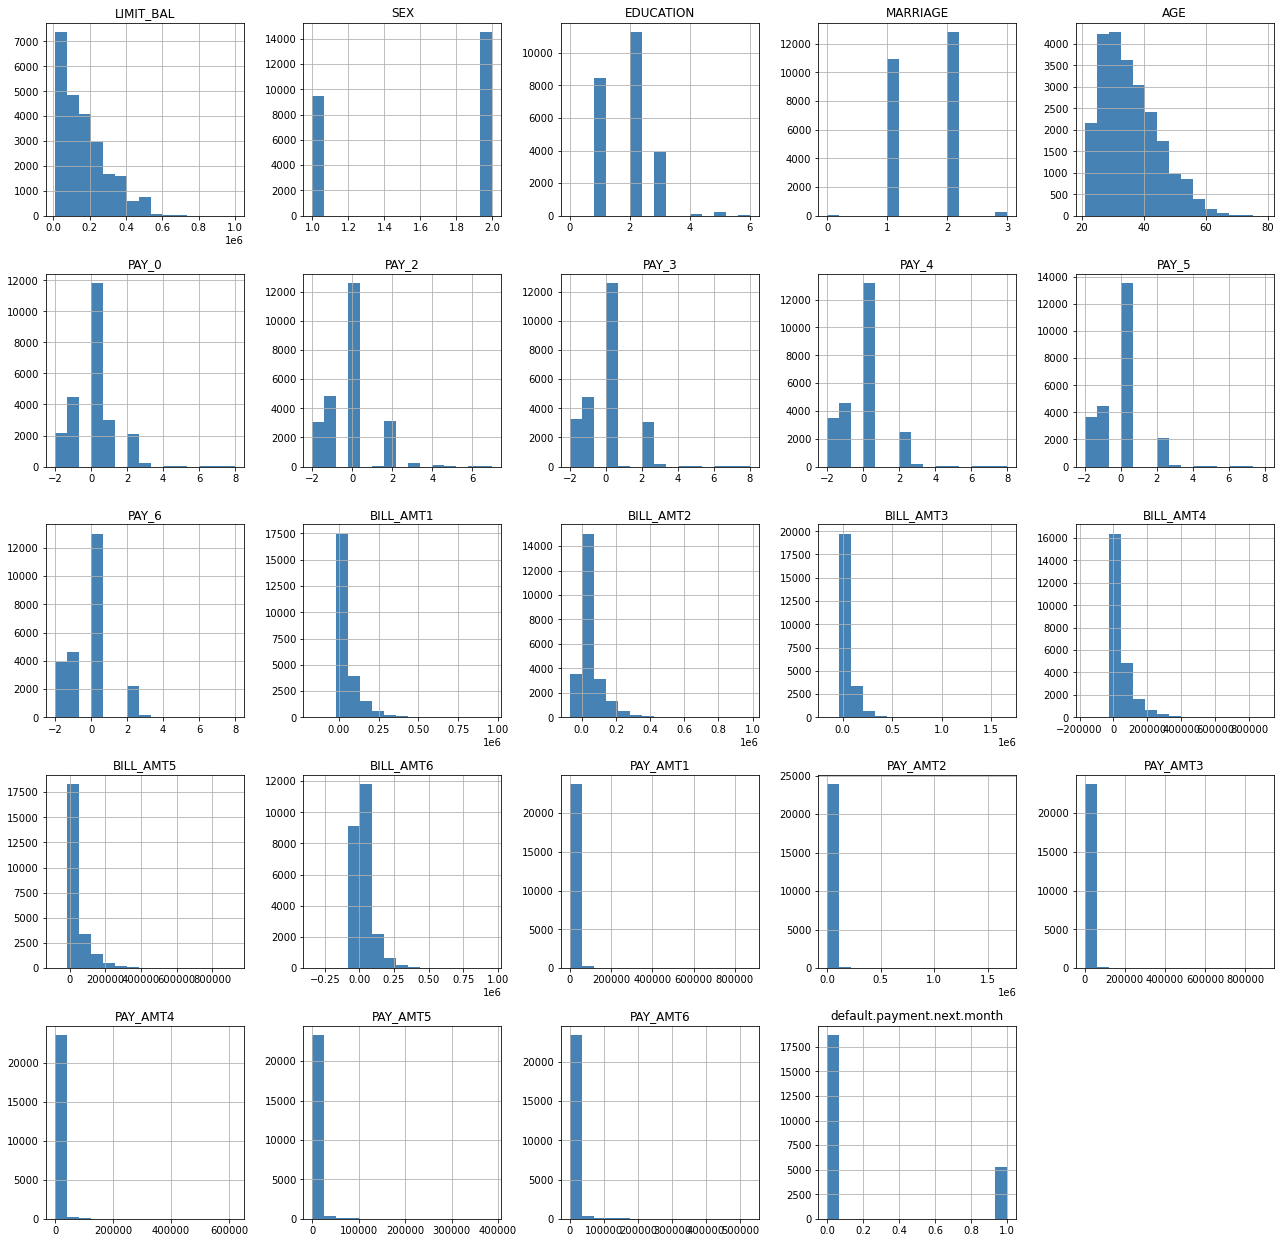

In [2]:
credit_df = pd.read_csv("UCI_Credit_Card.csv", index_col=0)
train_df, test_df = train_test_split(credit_df, test_size=0.2, random_state=321)
train_df.hist(figsize=(22, 22), bins=15, color='steelblue');

As shown in the plots, in some features, there are some outliers that might not help a lot for applying the models, such as in EDUCATION, MARRIAGE, or in all the PAY_AMT features.

## Preprocessing

Preprocessing is an essential step before fitting the ML models. Because the data in the dataset may be in different scales, and some of them are even not numerical, which will not be accepted by the models. As a result, we need to apply some methods to make sure they are transformed into the same type and scale, so it will be easier to fit the models later.

In [3]:
X_train_big, y_train_big = train_df.drop(columns=["default.payment.next.month"]), train_df["default.payment.next.month"]
X_test, y_test = test_df.drop(columns=["default.payment.next.month"]), test_df["default.payment.next.month"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
                    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
binary_features = ["SEX"]
categorical_features = ["MARRIAGE", "EDUCATION" ]
drop_features = ["ID"]

numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse=False))
binary_transformer = make_pipeline(OneHotEncoder(drop="if_binary", dtype=int))
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features), 
    (binary_transformer, binary_features),    
    (categorical_transformer, categorical_features),
#     ("drop", drop_features),
)

## Applying the Models

As mentioned earlier, in this project, multiple models are trained to obtain the final prediction. Since we are predicting whether a client will default the payment or not, this is a classic classification problem, which is to predict a binary result, instead of predicting a number. For this project, we used DummyClassifier as the baseline model. The DummyClassifier is not a smart model for classification, so it is expected to provide the lowest accuracy. Besides it, we also used Logistic Regression, Decision Tree Classifier, Random Forestry Classifier, and CatBoost Classifier. These are some useful and modern algorithms to deal with classification problems. We trained each model to fit this dataset, and compare their performance in the result part.

In [4]:
result={}

dummy = DummyClassifier(strategy="stratified")
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
cb = CatBoostClassifier(verbose=0)

pipe_dummy = make_pipeline(preprocessor, dummy);
pipe_lr = make_pipeline(preprocessor, lr);
pipe_dt = make_pipeline(preprocessor, dt);
pipe_rf = make_pipeline(preprocessor, rf);
pipe_cb = make_pipeline(preprocessor, cb);
C_vals = [0.001, 0.01, 0.1, 1.0, 10, 100]
param_grid = {
    "logisticregression__C": C_vals,
}
random_search = RandomizedSearchCV(
    pipe_lr, param_distributions=param_grid, n_jobs=1, n_iter=6, cv=5, random_state=123
)
random_search.fit(X_train, y_train)
lr_tuned = LogisticRegression(random_search.best_params_["logisticregression__C"]);
pipe_lr_tuned = make_pipeline(preprocessor, lr);

result_dummy = cross_validate(pipe_dummy, X_train, y_train, return_train_score=True);
result_lr = cross_validate(pipe_lr, X_train, y_train, return_train_score=True);
result_lr_tuned = cross_validate(pipe_lr_tuned, X_train, y_train, return_train_score=True);
result_dt = cross_validate(pipe_dt, X_train, y_train, return_train_score=True);
result_rf = cross_validate(pipe_rf, X_train, y_train, return_train_score=True);
result_cb = cross_validate(pipe_cb, X_train, y_train, return_train_score=True);

result["DummyClassifier"] = pd.DataFrame(result_dummy).mean()
result["LogisticRegression"] = pd.DataFrame(result_lr).mean()
result["LogisticRegressionTuned"] = pd.DataFrame(result_lr_tuned).mean()
result["DecisionTree"] = pd.DataFrame(result_dt).mean()
result["RandomForest"] = pd.DataFrame(result_rf).mean()
result["CatBoost"] = pd.DataFrame(result_cb).mean()
pd.DataFrame(result).T

,fit_time,score_time,test_score,train_score
DummyClassifier,0.013704,0.005948,0.655417,0.658199
LogisticRegression,0.172577,0.005966,0.680952,0.682500
LogisticRegressionTuned,0.168438,0.006031,0.680952,0.682500
DecisionTree,0.245251,0.006681,0.723750,0.999613
RandomForest,2.435686,0.058540,0.813274,0.999598
CatBoost,7.611312,0.036957,0.816488,0.864494


## Finding the Best Hyperparameter

In each model, hyperparameters are controlling the learning process. It is like the parameters in the math functions. For different hyperparameters, the outputs for the same inputs are different. When we trained the models, we found that it does not generate a satisfying score if we do not try to find the best hyperparameters for them. To optimize the prediction accuracy, we tried to find the best hyperparameter for the Random Forest Classifier model, which performed relatively well among all of the models we used, because its accuracy is only slightly lower than the highest one, which was obtained by CatBoost, but Random Forest model runs faster than CatBoost model. After that, we trained the model again with the best hyperparameter and reported the results.

In [6]:
from random import randint
n_estimator = [10,20,30,40,50,60,70,80,90,100]
max_depth = [10,20,30,40,50]
param_grid = {
    "randomforestclassifier__n_estimators": n_estimator,
    "randomforestclassifier__max_depth": max_depth,
}

random_search_rf = RandomizedSearchCV(pipe_rf, param_grid, n_iter=50, n_jobs=-1, cv=5,
#     scoring=scoring_metric,
#     random_state=123,
    return_train_score=True,
)
random_search_rf.fit(X_train, y_train);

rf_tuned = RandomForestClassifier(n_estimators=70, max_depth=10)
pipe_rf_tuned = make_pipeline(preprocessor, rf_tuned)
result_rf_tuned = cross_validate(pipe_rf_tuned, X_train, y_train, return_train_score=True)
result["RandomForestTuned"] = pd.DataFrame(result_rf_tuned).mean()
pd.DataFrame(result).T

,fit_time,score_time,test_score,train_score
DummyClassifier,0.013704,0.005948,0.655417,0.658199
LogisticRegression,0.172577,0.005966,0.680952,0.682500
LogisticRegressionTuned,0.168438,0.006031,0.680952,0.682500
DecisionTree,0.245251,0.006681,0.723750,0.999613
RandomForest,2.435686,0.058540,0.813274,0.999598
CatBoost,7.611312,0.036957,0.816488,0.864494
RandomForestTuned,1.021610,0.027108,0.816548,0.867054


## Feature Importance

Another critical question we need to solve is which feature is the most essential one in the prediction. To answer that, we used `eli5` to generate the score of each feature, which is a useful tool in ML. It is also useful to visualize the importance of each feature. As shown in the following colourful table, the top row with the darkest green is the most important feature determining whether a client will default or not, which is the payment status in September 2005. And this answers the second question of this project successfully.

In [7]:
import eli5
pipe_rf_tuned.fit(X_train, y_train)
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
feature_names = (
    numeric_features + binary_features + ohe_columns
)
eli5.explain_weights(
    pipe_rf_tuned.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.2255 ± 0.2039,PAY_0
0.1004 ± 0.1744,PAY_2
0.0745 ± 0.1617,PAY_3
0.0421 ± 0.0970,PAY_4
0.0420 ± 0.0450,PAY_AMT1
0.0399 ± 0.0253,BILL_AMT1
0.0385 ± 0.1153,PAY_5
0.0365 ± 0.0337,PAY_AMT2
0.0358 ± 0.0287,LIMIT_BAL
0.0340 ± 0.0216,BILL_AMT2


## Results

We have already determined the most important factor determining whether a client will default, the last question needed to be answered is which models provide the best performance in this project. From the previous parts, it is already known that the Random Forest Classifier predicts the most accurately, so we used the test dataset to perform a final evaluation. The final test score is 0.816167, which is a pretty descent result. Moreover, to visualize the results among all the models we have used, a graph is provided to compare the accuracy, as well as the time consumption. In the bar chart below, the aspects we examined for each model are drawn.

In [8]:
print("The test score of tuned Random Forest Classifier is %f" % (pipe_rf_tuned.score(X_test, y_test)))

The test score of tuned Random Forest Classifier is 0.815000


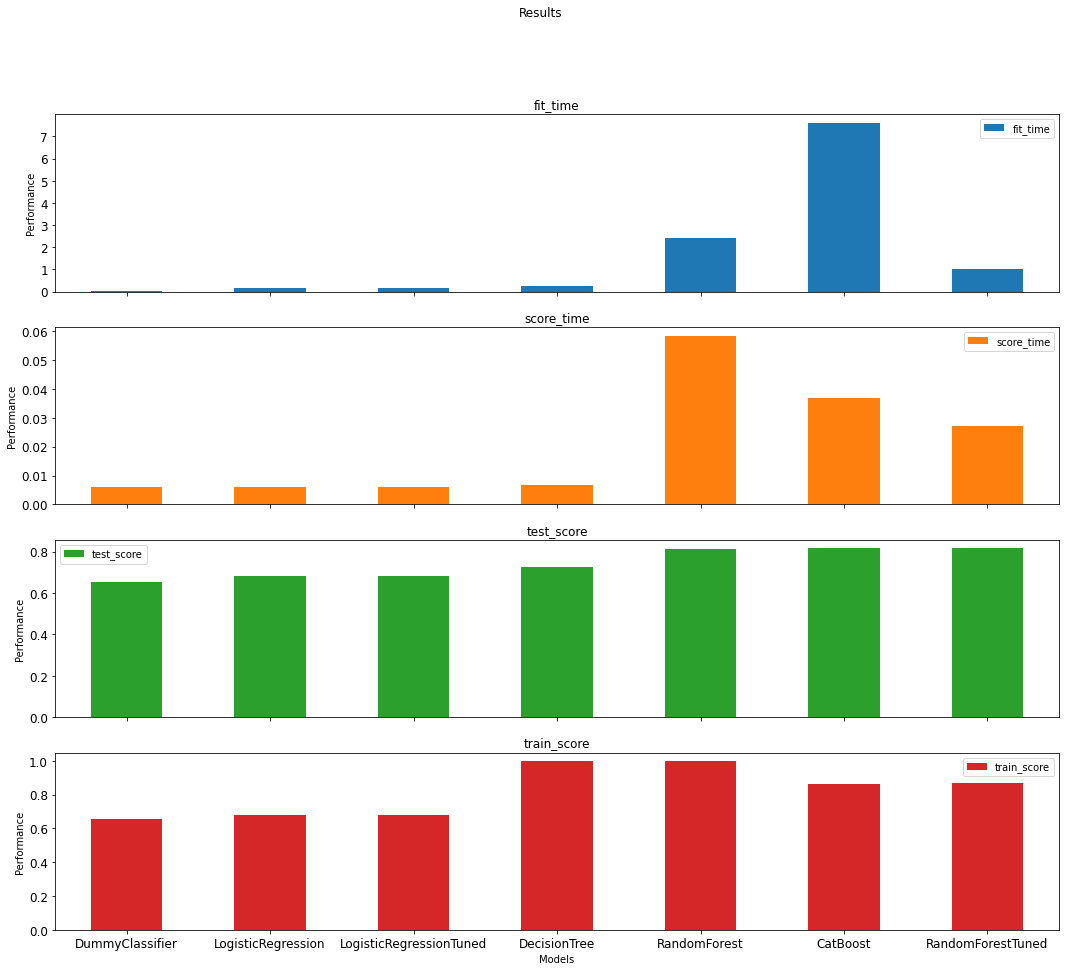

In [9]:
result_df = pd.DataFrame(result).T
bar = result_df.plot(kind="bar", title ="Results", xlabel="Models", ylabel="Performance",figsize=(18, 15), fontsize=12, rot=0, subplots=True)

## Discussion

In this project, the two questions proposed previously are both solved, and the results are provided clearly. It also proves that modern Machine Learning algorithms are powerful to make a prediction to deal with real-life demands. It will also be beneficial for companies to run better analyses, and make smarter decisions. Although the questions for this project are solved, there are still several improvements that could be made, such as finding other classifiers with both high accuracy and fast speed. To deal with it, some more advanced algorithms can be applied in the future.